# Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


spark = SparkSession.builder.master('local[3]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 43542)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/local/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates =

In [2]:
!pip install psutil
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 8.2 gigabytes of available RAM



In addition, we can get the degree of parallelism, i.e. the number of cores used.

In [3]:
spark.sparkContext.defaultParallelism

3

Create an RDD that multiplies their values by 2 and add the results.

In [3]:
from operator import add
rdd = sc.parallelize([1, 1, 1, 1, 2, 2, 2, 3, 3, 4])
rdd2 = rdd.map(lambda x: x*2)
tSum = rdd2.reduce(lambda x,y: x+y)
print (tSum)

40


Create a dictionary with elements (x,1) and sum the occurrences per element.

In [4]:
rdd_text = sc.parallelize(['red', 'red', 'blue', 'green', 'green','yellow'])
rdd_aux = rdd_text.map(lambda x: (x,1))
rdd_result = rdd_aux.reduceByKey(lambda x,y: x+y)
print (rdd_result.collect())

[('red', 2), ('green', 2), ('blue', 1), ('yellow', 1)]


Creation from dictionaries.

In [5]:
a = sc.parallelize(['a','b','c','a'])
b = sc.parallelize([1,2,3,4])
rdd_kv = a.zip(b)
print (rdd_kv.collect())

[('a', 1), ('b', 2), ('c', 3), ('a', 4)]


# DataFrames

Now, let's define our first PySpark DataFrame. The DataFrame in PySpark is like a spreadsheet that accommodates data. If you are already familiar with Pandas, you can safely assume that the PySpark DataFrame is something like the Pandas DataFrame (but with more powerful features). 

Let's read a dataset from a comma-separated values (CSV) file. PySpark comes with a convenient set of functions (also called 'methods' in Python) to read and parse some common data file formats, such as spark.read.csv() or spark.read.json(). Once the file contents are parsed, the values are returned as a PySpark DataFrame. The actual usage looks like this.

In [6]:
!wget -q https://github.com/chadwickbureau/baseballdatabank/raw/master/core/People.csv -O data/People.csv
df = spark.read.csv('data/People.csv', header=True, inferSchema=True)

In the above cell, we have downloaded the Major League Baseball dataset from the URL using the `wget` command (note: this is a linux command for downloading data from the web), and parsed it into a PySpark DataFrame named `df`.

Note that the `header=True` argument is used to indicate that the first row of the CSV file contains the name of the columns (parameters). If you set it to `None`, which is the default value, PySpark will only get some random column names and the first row of the CSV file will only be assumed to be part of the data entries.

To view the contents of a DataFrame, the `DataFrame.show()` method provides a simple way to check the raw data.


In [7]:
df.show()

+---+---------+---------+----------+--------+------------+------------+----------+---------+----------+--------+------------+----------+---------------+---------+-----------+----------------+------+------+----+------+----------+---------+----------+--------+
| ID| playerID|birthYear|birthMonth|birthDay|   birthCity|birthCountry|birthState|deathYear|deathMonth|deathDay|deathCountry|deathState|      deathCity|nameFirst|   nameLast|       nameGiven|weight|height|bats|throws|     debut|  bbrefID| finalGame| retroID|
+---+---------+---------+----------+--------+------------+------------+----------+---------+----------+--------+------------+----------+---------------+---------+-----------+----------------+------+------+----+------+----------+---------+----------+--------+
|  1|aardsda01|     1981|        12|      27|      Denver|         USA|        CO|     NULL|      NULL|    NULL|        NULL|      NULL|           NULL|    David|    Aardsma|     David Allan|   215|    75|   R|     R|2004-0

Another way to view the structure of the data is by printing, what is called, Schema. While the details will be explained several lines later, Schema defines the column name, the variable type, and the null of the data. Again, I'll explain those terms later, but for now, let's check what happens when we execute the DataFrame.printSchema() method.

### Show specific columns

Sometimes you may want to see some specific columns of the data frame. For those purposes, you can take advantage of Spark's SQL capabilities.

Using the `select()` function, you can mention any column you want to see

In [13]:
!wget https://raw.githubusercontent.com/timothypesi/Data-Sets-For-Machine-Learning-/main/california_housing_train.csv -O data/california_housing_train.csv
df = spark.read.csv("data/california_housing_train.csv", header=True, inferSchema=True)
df.select("longitude","latitude","median_house_value").show(5)

+---------+--------+------------------+
|longitude|latitude|median_house_value|
+---------+--------+------------------+
|  -114.31|   34.19|           66900.0|
|  -114.47|    34.4|           80100.0|
|  -114.56|   33.69|           85700.0|
|  -114.57|   33.64|           73400.0|
|  -114.57|   33.57|           65500.0|
+---------+--------+------------------+
only showing top 5 rows



### Describing columns 
Often, when working with numerical characteristics, we want to take a look at the statistics related to the data frame. The describe() function is best suited for such purposes.

It is quite similar to Panda's describe function, but the statistical values are much smaller and the string columns are also described.

In [10]:
df.describe().show()

+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|          longitude|          latitude|housing_median_age|      total_rooms|   total_bedrooms|        population|       households|     median_income|median_house_value|
+-------+-------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              17000|             17000|             17000|            17000|            17000|             17000|            17000|             17000|             17000|
|   mean|-119.56210823529375|  35.6252247058827| 28.58935294117647|2643.664411764706|539.4108235294118|1429.5739411764705|501.2219411764706| 3.883578100000021|207300.91235294117|
| stddev| 2.0051664084260357|2.1373397946570867|12.586936981660406|2179.947071452777|421.4994515798648| 1

In [14]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



## Some basic operations
Now that we understand the basic structure of Spark DataFrames, let's look at some basic operations that allow us to interact with the data.

In [15]:
!wget -q https://github.com/chadwickbureau/baseballdatabank/raw/master/core/Batting.csv -O data/Batting.csv
df = spark.read.csv('data/Batting.csv', header=True, inferSchema=True)
df.show()

+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+-----+
| playerID|yearID|stint|teamID|lgID|  G|G_batting| AB|  R|  H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB|HBP| SH| SF|GIDP|G_old|
+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+-----+
|aardsda01|  2004|    1|   SFN|  NL| 11|     NULL|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|   0| NULL|
|aardsda01|  2006|    1|   CHN|  NL| 45|     NULL|  2|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  1|  0|   0| NULL|
|aardsda01|  2007|    1|   CHA|  AL| 25|     NULL|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|   0| NULL|
|aardsda01|  2008|    1|   BOS|  AL| 47|     NULL|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|   0|  0|  0|  0|   0| NULL|
|aardsda01|  2009|    1|   SEA|  AL| 73|     NULL|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|   0| NULL|
|aardsda01|  201

### Column selection

As you analyze data, what you will often do is select a few subsets of columns from a data set and process them. In PySpark, selecting a column is as simple as `df['column_name']`.

In [16]:
df['playerID']

Column<'playerID'>

Note that the cell above prints a Spark column object. To see this more explicitly, you can run `type()` function in Python to check the data type.

In [17]:
type(df['playerID'])

pyspark.sql.column.Column

An important thing to remember here is that column objects are **not** the same as DataFrames. For example, the "show()" method that was available for regular DataFrames **will not work** with a column object. Therefore, it **assumes that the following cell returns a compilation error**:

In [18]:
df['playerID'].show()

TypeError: 'Column' object is not callable

So why did people bother to create a column data type? Well, as we'll see later, one reason is to use it as an efficient reference (something like a pointer) to a column. For now, however, it should be enough to understand that column objects are not DataFrames.

What should we do then, if we want to handle the columns as usual DataFrames? In other words, what should we do if we want to call the `show()` method to print the contents of a specific column? For this purpose, there is a `select()` method that can be called from a DataFrame. See the following example.

In [19]:
df.select('playerID')

DataFrame[playerID: string]

Now the type is DataFrame. Or more explicitly:

In [20]:
type(df.select('playerID'))

pyspark.sql.dataframe.DataFrame

And of course, since the column is now selected as a DataFrame, we can call any DataFrame method we want.

In [21]:
df.select('playerID').show()

+---------+
| playerID|
+---------+
|aardsda01|
|aardsda01|
|aardsda01|
|aardsda01|
|aardsda01|
|aardsda01|
|aardsda01|
|aardsda01|
|aardsda01|
|aaronha01|
|aaronha01|
|aaronha01|
|aaronha01|
|aaronha01|
|aaronha01|
|aaronha01|
|aaronha01|
|aaronha01|
|aaronha01|
|aaronha01|
+---------+
only showing top 20 rows



The column selection does not have to be a single column, but several columns can be selected at once. In this case, the names of the columns to be selected can be passed as a Python list. For example:

In [22]:
df.select( ['playerID', 'yearID'] ).show()

+---------+------+
| playerID|yearID|
+---------+------+
|aardsda01|  2004|
|aardsda01|  2006|
|aardsda01|  2007|
|aardsda01|  2008|
|aardsda01|  2009|
|aardsda01|  2010|
|aardsda01|  2012|
|aardsda01|  2013|
|aardsda01|  2015|
|aaronha01|  1954|
|aaronha01|  1955|
|aaronha01|  1956|
|aaronha01|  1957|
|aaronha01|  1958|
|aaronha01|  1959|
|aaronha01|  1960|
|aaronha01|  1961|
|aaronha01|  1962|
|aaronha01|  1963|
|aaronha01|  1964|
+---------+------+
only showing top 20 rows



### Row selection

As much as you need to select columns, you will also need to select rows. However, selecting rows is not as trivial as selecting columns. In fact, if you think about it, rows are basically data entries that are different on a case-by-case, sample-by-sample basis. Moreover, when the data is large, we are not talking about a small number of rows, but thousands or millions of them (or even more).

Therefore, row selection is often done by specifying some particular conditions. For example, you may want to select the first 10 rows of your DataFrame, which has already been sorted by some rules. You may also want to select rows that satisfy a certain condition. It is uncommon (especially in large data scenarios) to select rows using indexes, like what we have done for columns.

That said, here is our simplest example of selecting a few rows. Let's say you're interested in extracting the first 10 rows of a DataFrame. The "head()" method provides that very functionality.

In [23]:
df.head(10)

[Row(playerID='aardsda01', yearID=2004, stint=1, teamID='SFN', lgID='NL', G=11, G_batting=None, AB=0, R=0, H=0, 2B=0, 3B=0, HR=0, RBI=0, SB=0, CS=0, BB=0, SO=0, IBB=0, HBP=0, SH=0, SF=0, GIDP=0, G_old=None),
 Row(playerID='aardsda01', yearID=2006, stint=1, teamID='CHN', lgID='NL', G=45, G_batting=None, AB=2, R=0, H=0, 2B=0, 3B=0, HR=0, RBI=0, SB=0, CS=0, BB=0, SO=0, IBB=0, HBP=0, SH=1, SF=0, GIDP=0, G_old=None),
 Row(playerID='aardsda01', yearID=2007, stint=1, teamID='CHA', lgID='AL', G=25, G_batting=None, AB=0, R=0, H=0, 2B=0, 3B=0, HR=0, RBI=0, SB=0, CS=0, BB=0, SO=0, IBB=0, HBP=0, SH=0, SF=0, GIDP=0, G_old=None),
 Row(playerID='aardsda01', yearID=2008, stint=1, teamID='BOS', lgID='AL', G=47, G_batting=None, AB=1, R=0, H=0, 2B=0, 3B=0, HR=0, RBI=0, SB=0, CS=0, BB=0, SO=1, IBB=0, HBP=0, SH=0, SF=0, GIDP=0, G_old=None),
 Row(playerID='aardsda01', yearID=2009, stint=1, teamID='SEA', lgID='AL', G=73, G_batting=None, AB=0, R=0, H=0, 2B=0, 3B=0, HR=0, RBI=0, SB=0, CS=0, BB=0, SO=0, IBB=0, 

Notice that the row elements are returned as a Python list (look at the bracket!). This means that you can access the elements of the selected row as if you were accessing a value in a list.

In [24]:
df.head(10)[0] # elemento cero

Row(playerID='aardsda01', yearID=2004, stint=1, teamID='SFN', lgID='NL', G=11, G_batting=None, AB=0, R=0, H=0, 2B=0, 3B=0, HR=0, RBI=0, SB=0, CS=0, BB=0, SO=0, IBB=0, HBP=0, SH=0, SF=0, GIDP=0, G_old=None)

The data type of a row element is of type "row", or more explicitly, "pyspark.sql.types.Row". 

In [25]:
type(df.head(10)[0])

pyspark.sql.types.Row

### Adding columns

Another type of operation that can be quite useful is to add new columns. For example, let's say you invented a new characteristic (or baseball metric) called "stolen base success rate (SBSR)" defined as the number of stolen bases (SB) divided by the number of caught stealing (CS). (Of course, there are, for example, many players who never attempted to steal a single base, so there are no caught stealing. But let's not get too serious about this new metric.) For this, the following line can be quite useful.

In [26]:
df.withColumn('SBSR', df['SB']/df['CS']).show()

+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+-----+------------------+
| playerID|yearID|stint|teamID|lgID|  G|G_batting| AB|  R|  H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB|HBP| SH| SF|GIDP|G_old|              SBSR|
+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+-----+------------------+
|aardsda01|  2004|    1|   SFN|  NL| 11|     NULL|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|   0| NULL|              NULL|
|aardsda01|  2006|    1|   CHN|  NL| 45|     NULL|  2|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  1|  0|   0| NULL|              NULL|
|aardsda01|  2007|    1|   CHA|  AL| 25|     NULL|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|   0| NULL|              NULL|
|aardsda01|  2008|    1|   BOS|  AL| 47|     NULL|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|   0|  0|  0|  0|   0| NULL|              NULL|
|aards

First, `withColumn(<column name>, <value>)` is a method to create a new column. The `df.withColumn()` function creates a new DataFrame that has the same content as the original DataFrame `df`, but with an added column `<column name>`. Note that it does not change the original DataFrame `df`.

For the value, you can pass a reference to a column to be added. Of course, the column must have the same number of rows to be added to the existing DataFrame. One interesting thing here is that algebraic operations can be performed directly on the columns.

df['SB'] + df['CS'] + df['CS']

df['SB'] * df['CS']

df['SB'] / df['CS']

At this point, you will already notice that column objects have something special. At the beginning of this lab tutorial, I have emphasized that columnar objects must be distinguished from DataFrames. I have also mentioned that column objects are sort of pointers or references to the corresponding column in the DataFrame.

Well, to be more precise, column objects are essentially containers for queries. For example, a few lines ago, we saw that a Boolean operation like this `(df['yearID'] >= 2015) & (df['HR'] > 20) & (df['SB'] > 20)` creates a column object like this `Column<b'((yearID >= 2015) AND (HR > 20)) AND (SB > 20))>`. Just above, we also saw that columns could be added, subtracted, multiplied and divided and the result was something like this `Column<b'(SB / CS)'>`.

In fact, what happens here is that while we execute arithmetic/boolean operations on the columns, PySpark stores those operations as a query string in a column object. It doesn't actually execute real numeric operations at this point. So nothing is actually added, multiplied, or compared. Instead, the moment the column object is passed to a DataFrame method (e.g., `where()`, `withColumn()'), PySpark converts the query string into internally optimized Spark code and executes the query.

This is an important Spark design principle that you should understand. The choice behind this is actually quite obvious. It's obviously not a good idea to run computations every time a user enters code, because there can be many data entries in a big data problem and the data is typically distributed across multiple DataNodes. Instead, it is more beneficial to collect all queries until the end, and run them only once when the user requests to get actual results. Furthermore, when this happens, Spark optimizes queries in a way that is compatible with the database system it is running on (in our case, Hadoop), which is a secret recipe behind efficient distributed computing.

By understanding how PySpark handles queries, we have just opened a treasure chest of many tools. One of them is a set of mathematical functions that are predefined in PySpark. These functions can be loaded by importing the module `pyspark.sql.functions`.


With this, you can easily define new columns with custom processed values. Although I will not list the complete and exhaustive list of functions here, the following example will give you an idea of how these functions could be used. (For a complete list of functions, see https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions)

In [27]:
import pyspark.sql.functions as F
F.exp(df['SB']) + F.cos(df['SB'])
df.withColumn('exp(HR) + cos(SB)', F.exp(df['SB']) + F.cos(df['SB'])).show()

+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+-----+--------------------+
| playerID|yearID|stint|teamID|lgID|  G|G_batting| AB|  R|  H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB|HBP| SH| SF|GIDP|G_old|   exp(HR) + cos(SB)|
+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+-----+--------------------+
|aardsda01|  2004|    1|   SFN|  NL| 11|     NULL|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|   0| NULL|                 2.0|
|aardsda01|  2006|    1|   CHN|  NL| 45|     NULL|  2|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  1|  0|   0| NULL|                 2.0|
|aardsda01|  2007|    1|   CHA|  AL| 25|     NULL|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|   0| NULL|                 2.0|
|aardsda01|  2008|    1|   BOS|  AL| 47|     NULL|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|   0|  0|  0|  0|   0| NULL|              

### Sorting

Once it is clear how queries work in PySpark, the rest will be easy. For example, a DataFrame function that sorts rows according to a sort criterion is `sort()`. Meanwhile, a query function to define the ascending/descending order is `asc()`/`desc()`. With this, we can create a list of the top 10 MLB hitters in homers by season.

In [28]:
df.sort(df['hr'].desc()).limit(10).show()

+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+----+----+-----+
| playerID|yearID|stint|teamID|lgID|  G|G_batting| AB|  R|  H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB|HBP| SH|  SF|GIDP|G_old|
+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+----+----+-----+
|bondsba01|  2001|    1|   SFN|  NL|153|     NULL|476|129|156| 32|  2| 73|137| 13|  3|177| 93|  35|  9|  0|   2|   5| NULL|
|mcgwima01|  1998|    1|   SLN|  NL|155|     NULL|509|130|152| 21|  0| 70|147|  1|  0|162|155|  28|  6|  0|   4|   8| NULL|
| sosasa01|  1998|    1|   CHN|  NL|159|     NULL|643|134|198| 20|  0| 66|158| 18|  9| 73|171|  14|  1|  0|   5|  20| NULL|
|mcgwima01|  1999|    1|   SLN|  NL|153|     NULL|521|118|145| 21|  1| 65|147|  0|  0|133|141|  21|  2|  0|   5|  12| NULL|
| sosasa01|  2001|    1|   CHN|  NL|160|     NULL|577|146|189| 34|  5| 64|160|  0|  2|116|153|  37|  6|  0|  12|   6| NULL|
| sosasa

Multiple ranking conditions can also be specified. For example, the last two rows of the top 10 list has two players with 59 homeruns (HR). Suppose we want to sort them further by "HR", from low to high (ascending order). For this, the code below will do the job.

In [29]:
df.sort(df['hr'].desc(), df['rbi'].asc()).limit(10).show()

+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+----+----+-----+
| playerID|yearID|stint|teamID|lgID|  G|G_batting| AB|  R|  H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB|HBP| SH|  SF|GIDP|G_old|
+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+----+----+-----+
|bondsba01|  2001|    1|   SFN|  NL|153|     NULL|476|129|156| 32|  2| 73|137| 13|  3|177| 93|  35|  9|  0|   2|   5| NULL|
|mcgwima01|  1998|    1|   SLN|  NL|155|     NULL|509|130|152| 21|  0| 70|147|  1|  0|162|155|  28|  6|  0|   4|   8| NULL|
| sosasa01|  1998|    1|   CHN|  NL|159|     NULL|643|134|198| 20|  0| 66|158| 18|  9| 73|171|  14|  1|  0|   5|  20| NULL|
|mcgwima01|  1999|    1|   SLN|  NL|153|     NULL|521|118|145| 21|  1| 65|147|  0|  0|133|141|  21|  2|  0|   5|  12| NULL|
| sosasa01|  2001|    1|   CHN|  NL|160|     NULL|577|146|189| 34|  5| 64|160|  0|  2|116|153|  37|  6|  0|  12|   6| NULL|
| sosasa

Notice that the order has now been changed, so that when the "HR" is the same, the entries are sorted based on the ascending order of the "RBI".

### Joining tables

It is quite normal to store large data in different tables. For example, an online shopping mall may have separate tables of customer data, product data, inventory data, etc. In our baseball example there are also multiple database files such as player data, batting data, pitching data, salary data, etc. Therefore, knowing how to retrieve information from multiple DataFrames is critically important.

To see how this can be done in PySpark, let's now read two different csv files, "Batting.csv" and "People.csv". In fact, we have already downloaded these two files from the previous examples, so we can access them directly.

In [32]:
df_batting = spark.read.csv('data/Batting.csv', header=True, inferSchema=True)
df_people = spark.read.csv('data/People.csv', header=True, inferSchema=True)

Joining two DataFrames is as simple as `fd1.join(df2)`.

In [33]:
df_batting.join(df_people).show()

+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+-----+---+---------+---------+----------+--------+------------+------------+----------+---------+----------+--------+------------+----------+---------------+---------+-----------+----------------+------+------+----+------+----------+---------+----------+--------+
| playerID|yearID|stint|teamID|lgID|  G|G_batting| AB|  R|  H| 2B| 3B| HR|RBI| SB| CS| BB| SO|IBB|HBP| SH| SF|GIDP|G_old| ID| playerID|birthYear|birthMonth|birthDay|   birthCity|birthCountry|birthState|deathYear|deathMonth|deathDay|deathCountry|deathState|      deathCity|nameFirst|   nameLast|       nameGiven|weight|height|bats|throws|     debut|  bbrefID| finalGame| retroID|
+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+-----+---+---------+---------+----------+--------+------------+------------+----------+---------+----------+--------+----------

Of course, PySpark's `join()` function is not that smart, so if you try to get the actual result (remember that PySpark doesn't actually execute anything, but just accumulates queries, until you request the actual result), you should see an error:

The reason we see the above error is because the join operation is quite ambiguous. For example, `df_batting` and `df_people` have different number of rows and different entries. Therefore, there is no trivial way to join them.

To do so, you will need to specify key values to join two tables. In our case, the `playerID`s are the ones we can use to connect the two databases.

In [34]:
df_batting.join(df_people, on=['playerID']).show()

+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+-----+---+---------+----------+--------+---------+------------+----------+---------+----------+--------+------------+----------+---------+---------+--------+-----------+------+------+----+------+----------+---------+----------+--------+
| playerID|yearID|stint|teamID|lgID|  G|G_batting| AB|  R|  H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB|HBP| SH| SF|GIDP|G_old| ID|birthYear|birthMonth|birthDay|birthCity|birthCountry|birthState|deathYear|deathMonth|deathDay|deathCountry|deathState|deathCity|nameFirst|nameLast|  nameGiven|weight|height|bats|throws|     debut|  bbrefID| finalGame| retroID|
+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+-----+---+---------+----------+--------+---------+------------+----------+---------+----------+--------+------------+----------+---------+---------+--------+-----------+------+--

### Agregations

Now the last topic for this lab tutorial is data aggregation. For example, the batting statistics we have are based on each season. In other words, the same player may have multiple rows of his record if he played more than one season. Now suppose we are interested in career homerun records (i.e., how many homeruns a player has hit over his entire career), rather than season records. To do this, we need to be able to aggregate all the rows corresponding to each player by adding them together.

So far, we have learned how to order the values in a DataFrame

In [35]:
df_batting.sort(df_batting['hr'].desc()).limit(10).show()

+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+----+----+-----+
| playerID|yearID|stint|teamID|lgID|  G|G_batting| AB|  R|  H| 2B| 3B| HR|RBI| SB| CS| BB| SO| IBB|HBP| SH|  SF|GIDP|G_old|
+---------+------+-----+------+----+---+---------+---+---+---+---+---+---+---+---+---+---+---+----+---+---+----+----+-----+
|bondsba01|  2001|    1|   SFN|  NL|153|     NULL|476|129|156| 32|  2| 73|137| 13|  3|177| 93|  35|  9|  0|   2|   5| NULL|
|mcgwima01|  1998|    1|   SLN|  NL|155|     NULL|509|130|152| 21|  0| 70|147|  1|  0|162|155|  28|  6|  0|   4|   8| NULL|
| sosasa01|  1998|    1|   CHN|  NL|159|     NULL|643|134|198| 20|  0| 66|158| 18|  9| 73|171|  14|  1|  0|   5|  20| NULL|
|mcgwima01|  1999|    1|   SLN|  NL|153|     NULL|521|118|145| 21|  1| 65|147|  0|  0|133|141|  21|  2|  0|   5|  12| NULL|
| sosasa01|  2001|    1|   CHN|  NL|160|     NULL|577|146|189| 34|  5| 64|160|  0|  2|116|153|  37|  6|  0|  12|   6| NULL|
| sosasa

To do this, we go to the first rows of the group by "playerID".

In [36]:
df_batting.groupby('playerid')

GroupedData[grouping expressions: [playerid], value: [playerID: string, yearID: int ... 22 more fields], type: GroupBy]

This creates a grouped DataFrame where the rows are ready to be aggregated by the "playerID". Since we want the total number of homeruns in the race, the aggregation method of our choice is "sum".

As can be seen from the above, the `sum()` method creates a new DataFrame composed of aggregated column values. There are other aggregation methods such as `avg()`, `max()`, `min()`, etc., whose functions are quite self-explanatory. (For an exhaustive list, see https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.GroupedData).

In [37]:
df_batting.groupby('playerid').sum().show()

+---------+-----------+----------+------+--------------+-------+------+------+-------+-------+-------+--------+-------+-------+-------+-------+--------+--------+-------+-------+---------+
| playerid|sum(yearID)|sum(stint)|sum(G)|sum(G_batting)|sum(AB)|sum(R)|sum(H)|sum(2B)|sum(3B)|sum(HR)|sum(RBI)|sum(SB)|sum(CS)|sum(BB)|sum(SO)|sum(IBB)|sum(HBP)|sum(SH)|sum(SF)|sum(GIDP)|
+---------+-----------+----------+------+--------------+-------+------+------+-------+-------+-------+--------+-------+-------+-------+-------+--------+--------+-------+-------+---------+
|adamsac01|      11661|         6|   302|          NULL|     99|     9|    12|      0|      0|      0|       2|      0|      0|      6|     14|       0|       0|      8|      0|        2|
|alanirj01|       6059|         4|    15|          NULL|      2|     0|     1|      0|      0|      0|       1|      0|      0|      0|      1|       0|       0|      0|      0|        0|
|albercy01|       1910|         1|     4|          NULL|    

## SQL

If you are already familiar with SQL, Spark allows you to create queries using SQL. While this is beyond the scope of this class, I think it may be useful to some of you and therefore provide an example below.



In [38]:
df_people = spark.read.csv('data/People.csv', header=True, inferSchema=True)
df_people.createOrReplaceTempView('people')

In [40]:
results = spark.sql("SELECT * FROM people")
results.show()

+---+---------+---------+----------+--------+------------+------------+----------+---------+----------+--------+------------+----------+---------------+---------+-----------+----------------+------+------+----+------+----------+---------+----------+--------+
| ID| playerID|birthYear|birthMonth|birthDay|   birthCity|birthCountry|birthState|deathYear|deathMonth|deathDay|deathCountry|deathState|      deathCity|nameFirst|   nameLast|       nameGiven|weight|height|bats|throws|     debut|  bbrefID| finalGame| retroID|
+---+---------+---------+----------+--------+------------+------------+----------+---------+----------+--------+------------+----------+---------------+---------+-----------+----------------+------+------+----+------+----------+---------+----------+--------+
|  1|aardsda01|     1981|        12|      27|      Denver|         USA|        CO|     NULL|      NULL|    NULL|        NULL|      NULL|           NULL|    David|    Aardsma|     David Allan|   215|    75|   R|     R|2004-0

In [41]:
spark.sql("SELECT * FROM people WHERE birthYear>1990").show()

+---+---------+---------+----------+--------+--------------------+------------+------------------+---------+----------+--------+------------+----------+---------+---------+--------+-----------------+------+------+----+------+----------+---------+----------+--------+
| ID| playerID|birthYear|birthMonth|birthDay|           birthCity|birthCountry|        birthState|deathYear|deathMonth|deathDay|deathCountry|deathState|deathCity|nameFirst|nameLast|        nameGiven|weight|height|bats|throws|     debut|  bbrefID| finalGame| retroID|
+---+---------+---------+----------+--------+--------------------+------------+------------------+---------+----------+--------+------------+----------+---------+---------+--------+-----------------+------+------+----+------+----------+---------+----------+--------+
| 11|abbotco01|     1995|         9|      20|           San Diego|         USA|                CA|     NULL|      NULL|    NULL|        NULL|      NULL|     NULL|     Cory|  Abbott|       Cory James|

# Matplotlib visualization

Now let's take an in-depth look at the Matplotlib package for visualization in Python. Matplotlib is a cross-platform data visualization library built on top of NumPy arrays, and designed to work with the broader SciPy stack. It was conceived by John Hunter in 2002, originally as a patch for IPython to allow interactive MATLAB-style plotting via gnuplot from the IPython command line. The creator of IPython, Fernando Perez, was at the time struggling to finish his PhD, and let John know that he would not have time to review the patch for several months. John took this as a signal to strike out on his own, and so the Matplotlib package was born, with version 0.1 released in 2003. It received an early boost when it was adopted as the plotting package of choice by the Space Telescope Science Institute (the folks behind the Hubble Telescope), which financially supported Matplotlib's development and greatly expanded its capabilities.

One of the most important features of Matplotlib is its ability to work well with many operating systems and graphics supports. Matplotlib supports dozens of backends and output types, which means you can count on it to work regardless of the operating system you are using or the output format you want. This cross-platform, all-for-all approach has been one of Matplotlib's great strengths. It has led to a large user base, which in turn has led to an active developer base and to Matplotlib's powerful tools and ubiquity within the scientific Python world.

## Importing dependencies

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt

## Style

## Line

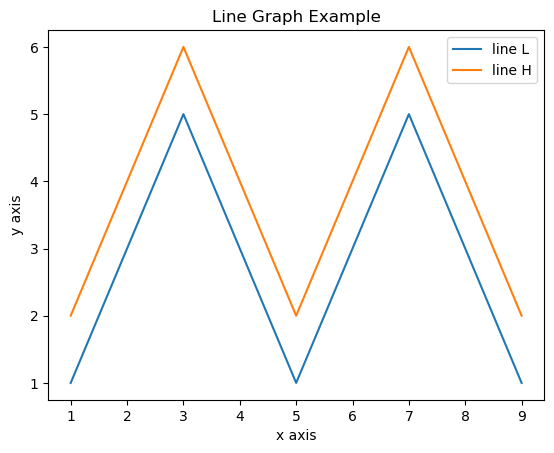

In [38]:
x  = [1, 2, 3, 4, 5, 6, 7, 8, 9]
y1 = [1, 3, 5, 3, 1, 3, 5, 3, 1]
y2 = [2, 4, 6, 4, 2, 4, 6, 4, 2]
plt.plot(x, y1, label="line L")
plt.plot(x, y2, label="line H")
plt.plot()

plt.xlabel("x axis")
plt.ylabel("y axis")
plt.title("Line Graph Example")
plt.legend()
plt.show()

## Bars

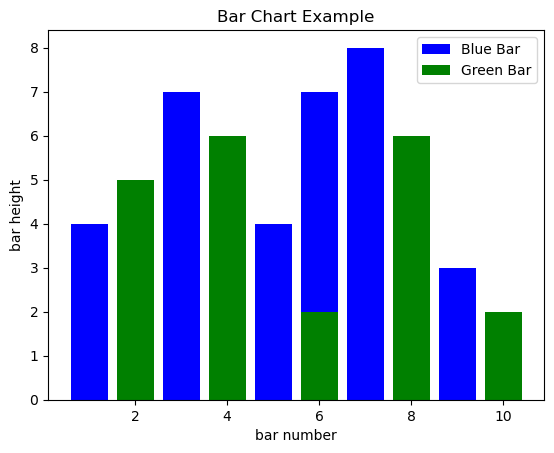

In [39]:
# Look at index 4 and 6, which demonstrate overlapping cases.
x1 = [1, 3, 4, 5, 6, 7, 9]
y1 = [4, 7, 2, 4, 7, 8, 3]

x2 = [2, 4, 6, 8, 10]
y2 = [5, 6, 2, 6, 2]

# Colors: https://matplotlib.org/api/colors_api.html

plt.bar(x1, y1, label="Blue Bar", color='b')
plt.bar(x2, y2, label="Green Bar", color='g')
plt.plot()

plt.xlabel("bar number")
plt.ylabel("bar height")
plt.title("Bar Chart Example")
plt.legend()
plt.show()

## Histograms

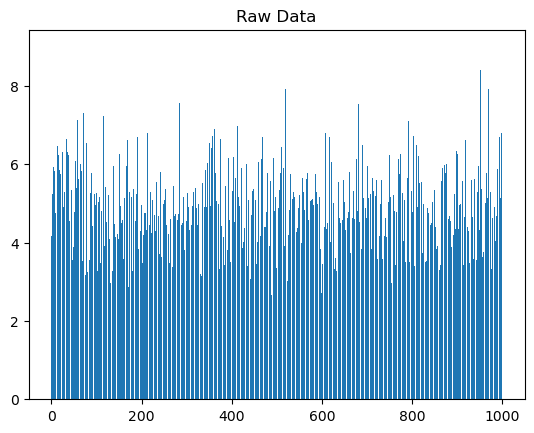

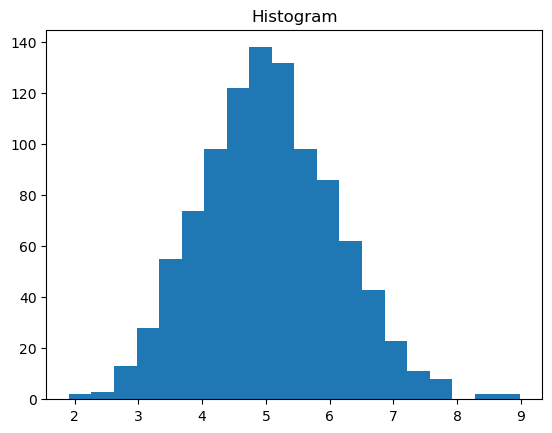

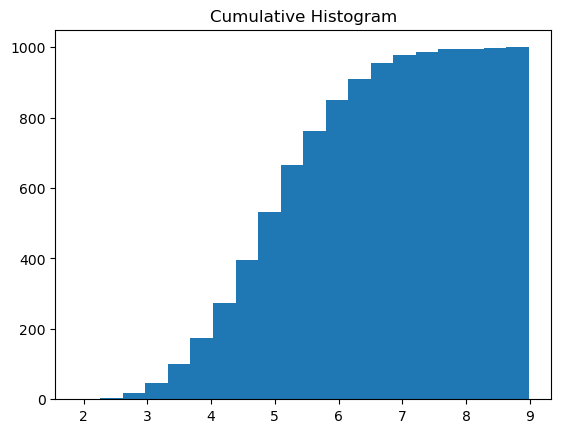

In [42]:
import numpy as np
# Use numpy to generate a bunch of random data in a bell curve around 5.
n = 5 + np.random.randn(1000)

m = [m for m in range(len(n))]
plt.bar(m, n)
plt.title("Raw Data")
plt.show()

plt.hist(n, bins=20)
plt.title("Histogram")
plt.show()

plt.hist(n, cumulative=True, bins=20)
plt.title("Cumulative Histogram")
plt.show()

## Scatter

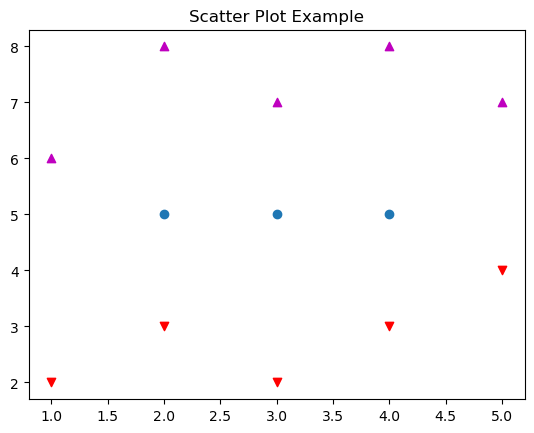

In [43]:
x1 = [2, 3, 4]
y1 = [5, 5, 5]

x2 = [1, 2, 3, 4, 5]
y2 = [2, 3, 2, 3, 4]
y3 = [6, 8, 7, 8, 7]

# Markers: https://matplotlib.org/api/markers_api.html

plt.scatter(x1, y1)
plt.scatter(x2, y2, marker='v', color='r')
plt.scatter(x2, y3, marker='^', color='m')
plt.title('Scatter Plot Example')
plt.show()

## Save graphics to disk
A nice feature of Matplotlib is the ability to save figures in a wide variety of formats. Saving a figure can be done using the savefig() command. For example, to save the above figure as a PNG file, you can run this:

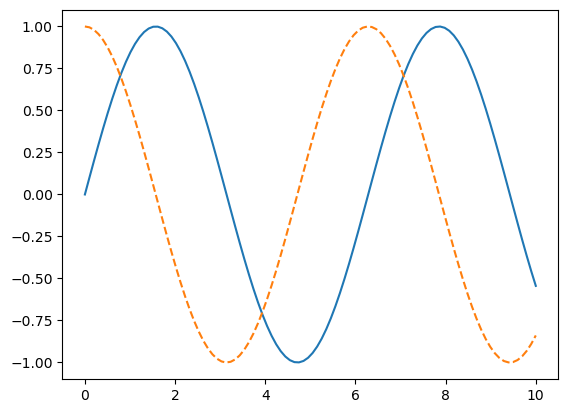

In [44]:
x = np.linspace(0, 10, 100)

fig = plt.figure()
plt.plot(x, np.sin(x), '-')
plt.plot(x, np.cos(x), '--');

fig.savefig('output/my_figure.png')

# Pandas

In [45]:
import numpy as np
import pandas as pd

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Generate a pandas DataFrame
pdf = pd.DataFrame(np.random.rand(100, 3))

# Create a Spark DataFrame from a pandas DataFrame using Arrow
df = spark.createDataFrame(pdf)

# Convert the Spark DataFrame back to a pandas DataFrame using Arrow
result_pdf = df.select("*").toPandas()

https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html

# Examples

## Number PI calculation

In [42]:
from time import time
import numpy as np
from random import random
from operator import add

sc = spark.sparkContext

n = 100000000


def is_point_inside_unit_circle(p):
    # p is useless here
    x, y = random(), random()
    return 1 if x*x + y*y < 1 else 0


t_0 = time()

# parallelize creates a spark Resilient Distributed Dataset (RDD)
# its values are useless in this case
# but allows us to distribute our calculation (inside function)
count = sc.parallelize(range(0, n)) \
             .map(is_point_inside_unit_circle).reduce(add)
print(np.round(time()-t_0, 3), "seconds elapsed for Spark approach and n =",n)
print("Pi is roughly %f" % (4.0 * count / n))

34.307 seconds elapsed for Spark approach and n = 100000000
Pi is roughly 3.141326


# Twitter
Let's calculate the trending topic of twitter, processing a small amount of data.

In [31]:
# extract data
twitter = spark.read.json("data/twitter/")

In [32]:
# analyze data
print(f"Number of tweets: {twitter.count()}")
twitter.printSchema()

Number of tweets: 161801
root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- delete: struct (nullable = true)
 |    |-- status: struct (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- id_str: string (nullable = true)
 |    |    |-- user_id: long (nullable = true)
 |    |    |-- user_id_str: string (nullable = true)
 |    |-- timestamp_ms: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (

We'll compute the trending topic by doing a word count of the hashtags inside the `text` field.

## Using SQL

First let's extract the `text` field, excluding `NULL`s.

In [33]:
twitter.createOrReplaceTempView("tweets")
t = spark.sql("SELECT text FROM tweets WHERE text IS NOT NULL")
t.show()

+-------------------------------------+
|                                 text|
+-------------------------------------+
|                  @tearies ドナドナー|
|                RT @kkangssoo0: 솔...|
|そこには、引力だけが残り、ブラック...|
|                 RT @Billystafford...|
|                           (みえない)|
|    車ってのは、1tの鉄の塊だ。\nこ...|
|       これがミスの第一号だ…………こい!!|
|                 RT @ppinkqx: เป็น...|
|                 RT @majhood8999: ...|
|                           STROBE.ISO|
|                 RT @ashlynnnn_: L...|
|                 RT @MatiAlbornoz1...|
|                 @BrGuedes Já li, ...|
|                 On Air: #NowPlayi...|
|                 Me siento cambiad...|
|                 @pecafranco @maji...|
|          @miyomaki すごい気になるwww|
|                 RT @dewahoya: Kom...|
|           @maid_nono 来たらとりあ...|
|                 RT @Pejirider_555...|
+-------------------------------------+
only showing top 20 rows



Now we'll separate each text in words, and filter hashtags.

In order to do a `.map`, we need to downgrade from a DataFrame to an RDD.  
As each element of the RDD is a row of one column, we extract the first column, filter out `None` values, split by words (and flat map), and filter hashtags. Finally, we generate the tuples, and reduce.

In [34]:
from operator import add

result = t.rdd.map(lambda x: x[0]).flatMap(lambda x: x.split()).filter(lambda x: x.startswith("#")).map(lambda x: (x, 1)).reduceByKey(add)

Finally, we'll sort by number of words, and take the top 10.

In [35]:
result.sortBy(lambda x: x[1], False).take(10)

[('#PREMIOSMTVMIAW', 2268),
 ('#MTVINSTAMXBAUTISTA', 658),
 ('#VeranoMTV2017', 510),
 ('#PRODUCE101', 501),
 ('#BAMA2017DiamondEdition_SuperJunior', 455),
 ('#MTVINSTAARVICICONTE', 430),
 ('#MTVINSTAMXDANNA', 421),
 ('#M…', 340),
 ('#مسابقه_الوليد_شفاه_الله_7', 328),
 ('#MTVFRESCAJANCARLO', 318)]

## Using Pyspark SQL

First let's extract the `text` field, excluding `NULL`s.

In [36]:
twitter.createOrReplaceTempView("tweets")
t = twitter.select(['text']).na.drop()

For splitting the words, we'll temporarily use RDDs due to the `.flatMap` method, and generate the tuples.

In [37]:
t = t.rdd.map(lambda x: x[0]).flatMap(lambda x: x.split()).map(lambda x: (x, 1))

We'll go back to a DataFrame for filtering. It's less efficient to do it after the tuple generation in this specific case, but it's just to show how to do it.

In [38]:
t2 = t.toDF().withColumnRenamed("_1", "hashtag").withColumnRenamed("_2", "count")
t2.show()

+------------+-----+
|     hashtag|count|
+------------+-----+
|    @tearies|    1|
|  ドナドナー|    1|
|          RT|    1|
|@kkangssoo0:|    1|
|      솔직히|    1|
|        오늘|    1|
|    방송에서|    1|
|    하성운이|    1|
|    어른이다|    1|
|      싶었다|    1|
|        진짜|    1|
|      자존심|    1|
|        상할|    1|
|          수|    1|
|        있는|    1|
|    상황인데|    1|
|        금방|    1|
|      분위기|    1|
|    전환하고|    1|
|      최선을|    1|
+------------+-----+
only showing top 20 rows



We'll then sum all the counts, using `.groupBy`. This will generate a new `sum(count)` column, that we can rename to `count`.  
We then descending sort by `count`, and show the results.

In [39]:
t3 = t2.where("hashtag LIKE '#%'").groupBy('hashtag').sum().withColumnRenamed("sum(count)", "count")
t3.sort(t3['count'].desc()).show(10)

+--------------------+-----+
|             hashtag|count|
+--------------------+-----+
|     #PREMIOSMTVMIAW| 2268|
| #MTVINSTAMXBAUTISTA|  658|
|      #VeranoMTV2017|  510|
|         #PRODUCE101|  501|
|#BAMA2017DiamondE...|  455|
|#MTVINSTAARVICICONTE|  430|
|    #MTVINSTAMXDANNA|  421|
|                 #M…|  340|
|#مسابقه_الوليد_شف...|  328|
|  #MTVFRESCAJANCARLO|  318|
+--------------------+-----+
only showing top 10 rows

